# ステップ１０　拡散モデルの応用
Midjourney や Stable Diffusion は条件付き拡散モデルで実現できる．

## 10.1 条件付き拡散モデル
いままではp(x)のモデル化を行ってきた．しかし，条件付き確率p(x|y)をモデル化した方が，条件yによって出力xをコントロールできて嬉しい．  
条件yとしてテキスト・画像・ラベルなどが当てはまる．例として，低解像度画像→高解像度画像にする使い方がある（**超画像**）．   
今回はラベルを条件yとして，MNISTの画像において，数字ラベルを与えた時に，そのラベルに対応する画像を出力することを目指す．

### 10.1.1 拡散モデルに条件を追加する
##### ① $\mu_\theta (x_t, t)$のモデル化
![mu_model](./data/mu.jpg)
##### ② $\epsilon_\theta (x_t, t)$のモデル化
![epsilon_model](./data/ipsilon.jpg)

##### ①の$\mu_\theta (x_t, t)$のモデル化を行う

$$p_\theta(x_{t-1}\mid x_t)=\mathcal{N}\!\bigl(x_{t-1};\,\bm{\mu}_\theta(x_t,t),\,\sigma_q^2(t)\bm{I}\bigr)$$

$$
\begin{align*}
p_\theta(x_0) &= \int p_\theta(x_0, x_1, \ldots, x_T)\, dx_1 \cdots dx_T 　\text{（確率の周辺化）}\\
              &= \int p_\theta(x_0\mid x_1)\ \cdots p_\theta(x_{T-1}\mid x_T)\, p(x_T)\, dx_1 \cdots dx_T　\text{（マルコフ性）}
\end{align*}
$$
$$\text{このとき，}p(x_T)=\mathcal{N}(x_T;\,\bm{0},\,\bm{I})$$
<bm>

条件yがあるときの，$p_{\theta}(x_0 | y)$のモデル化より，以下のようになる．
$$p_\theta(x_0\mid y)=\int p_\theta(x_0\mid x_1,y)\,\cdots p_\theta(x_{T-1}\mid x_T,y)\,p(x_T)\,dx_1\cdots dx_T$$

$$\text{このとき，}p_\theta(x_{t-1}\mid x_t,y)=\mathcal{N}\!\bigl(x_{t-1};\,\bm{\mu}_\theta(x_t,t,y),\,\sigma_q^2(t)\bm{I}\bigr)$$

### 10.1.2 条件付き拡散モデルの実装
![10_4](./data/10_4.jpg)


In [2]:
import math
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
import random, numpy as np, torch

# ① 共通シード設定関数
def seed_min(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)   # GPU も一括
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_min(42)

# ② DataLoader の乱数源を固定（shuffle の順序が安定）
gen = torch.Generator().manual_seed(42)

In [10]:
# 可視化関数（9章より）

"""
grid表示用の画像を表示する関数（学習後ラベルごとにサンプリング）
    images: 画像のリストまたは配列
    rows: 行数
    cols: 列数
"""
def show_images(images, labels=None, rows=2, cols=10):
    fig = plt.figure(figsize=(cols, rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax = fig.add_subplot(rows, cols, i + 1) # 各ラベルごとにサブプロットを作成
            plt.imshow(images[i], cmap='gray') # グレースケールで画像表示
            if labels is not None:
                ax.set_xlabel(labels[i].item()) # ラベルを表示
            ax.get_xaxis().set_ticks([]) # 目盛非表示
            ax.get_yaxis().set_ticks([]) # 目盛非表示
            i += 1
    plt.tight_layout()
    plt.show()

In [11]:
# 正弦波エンコーディング（9章より）

def _pos_encoding(time_idx, output_dim, device='cpu'):
    t, D = time_idx, output_dim
    v = torch.zeros(D, device=device)

    i = torch.arange(0, D, device=device)
    div_term = torch.exp(i / D * math.log(10000)) # = 10000**(i/D)

    v[0::2] = torch.sin(t / div_term[0::2]) # 偶数次元はsin
    v[1::2] = torch.cos(t / div_term[1::2]) # 奇数次元はcos
    return v

def pos_encoding(timesteps, output_dim, device='cpu'): # バッチ対応版
    batch_size = len(timesteps)
    # device = timesteps.device # テンソルが乗ってるデバイスに変換
    v = torch.zeros(batch_size, output_dim, device=device)
    for i in range(batch_size): # 各バッチでエンコーディング
        v[i] = _pos_encoding(timesteps[i], output_dim, device)
    return v

In [12]:
# Unetをつかった条件付き生成モデルの定義

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), # 3*3畳込み，パディング1，チャネル数変換
            nn.BatchNorm2d(out_ch), # バッチ正規化
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        self.mlp = nn.Sequential( # 全結合
            nn.Linear(time_embed_dim, in_ch), # 時間埋め込みをチャネル数に変換
            nn.ReLU(),
            nn.Linear(in_ch, in_ch) # チャネル数と同じ次元のベクトルに変換
        )

    def forward(self, x, v): # 入力と時間ベクトルを結合
        N, C, _, _ = x.shape
        v = self.mlp(v)
        v = v.view(N, C, 1, 1)
        y = self.convs(x + v)
        return y
    
class UNetCond(nn.Module):
    def __init__(self, in_ch=1, time_embed_dim=100, num_labels=None):
        super().__init__()
        self.time_embed_dim = time_embed_dim

        self.down1 = ConvBlock(in_ch, 64, time_embed_dim)
        self.down2 = ConvBlock(64, 128, time_embed_dim)
        self.bot1 = ConvBlock(128, 256, time_embed_dim)
        self.up2 = ConvBlock(128 + 256, 128, time_embed_dim)
        self.up1 = ConvBlock(128 + 64, 64, time_embed_dim)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

        # 変更箇所①：ラベル処理の埋め込み層（埋め込み＝数値ベクトル変換）
        if num_labels is not None:
            # ラベル数が，time_embed_dimの次元数と同じになるように設定
            self.label_emb = nn.Embedding(num_labels, time_embed_dim)

    def forward(self, x, timesteps, labels=None):
        t = pos_encoding(timesteps, self.time_embed_dim) # t = vのこと

        # 変更箇所②：ラベルがある場合はtに加算して追加処理
        if labels is not None:
            t += self.label_emb(labels)

        x1 = self.down1(x, t)
        x = self.maxpool(x1)
        x2 = self.down2(x, t)
        x = self.maxpool(x2)

        x = self.bot1(x, t)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x, t)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x, t)
        x = self.out(x)
        return x

In [17]:
# Diffusionモデルの定義

class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all() # 1以上T以下の整数であることを確認

        t_idx = t - 1  # alpha_bars[0] is for t=1
        alpha_bar = self.alpha_bars[t_idx]  # (N,)
        alpha_bar = alpha_bar.view(alpha_bar.size(0), 1, 1, 1)  # (N, 1, 1, 1)

        noise = torch.randn_like(x_0, device=self.device) # 元画像x0と同じ形状のノイズテンソル
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise # 変数変換トリック
        return x_t, noise # 時刻tのノイズ画像, ノイズ

    def denoise(self, model, x, t, labels):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all() # 1以上T以下の整数であることを確認

        t_idx = t - 1  # alphas[0] is for t=1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx-1]

        # ブロードキャストのための形状変換
        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval()
        with torch.no_grad(): # 評価時には，勾配計算を無効化
            # 変更箇所③：ラベルをモデルに渡す
            eps = model(x, t, labels) # noiseである\epsilonの予測
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0  # t=1のときはノイズを0にする（最初の画像はノイズなし）

        mu = (x - ((1-alpha) / torch.sqrt(1-alpha_bar)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1-alpha) * (1-alpha_bar_prev) / (1-alpha_bar))
        return mu + noise * std

    def reverse_to_img(self, x): # テンソルxからPILイメージに変換（前処理でテンソルにしているため）
        x = x * 255
        x = x.clamp(0, 255) # 0-255の範囲に制限
        x = x.to(torch.uint8)
        x = x.cpu()
        to_pil = transforms.ToPILImage() # テンソルをPIL画像に変換
        return to_pil(x)

    def sample(self, model, x_shape=(20, 1, 28, 28), labels=None, gamma=3.0): # サンプリング関数（生成）
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device)

        # 変更箇所④：ラベルが指定されていない場合はランダムに生成
        if labels is None:
            labels = torch.randint(0, 10, (len(x),), device=self.device) # len(x)はバッチサイズ

        for i in tqdm(range(self.num_timesteps, 0, -1)):
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)
            x = self.denoise(model, x, t, labels)

        images = [self.reverse_to_img(x[i]) for i in range(batch_size)]
        return images, labels

In [32]:
# ハイパーパラメータの設定

img_size = 28
batch_size = 128
num_timesteps = 1000
epochs = 10
lr = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

##### 学習フェーズ

100%|██████████| 1000/1000 [00:41<00:00, 24.12it/s]


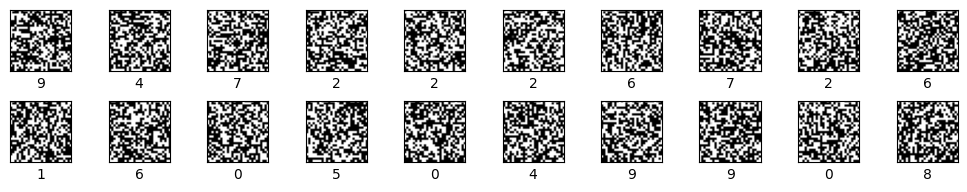

100%|██████████| 469/469 [04:53<00:00,  1.60it/s]


Epoch 0 | Loss: 0.050686654398468006


100%|██████████| 1000/1000 [00:52<00:00, 18.89it/s]


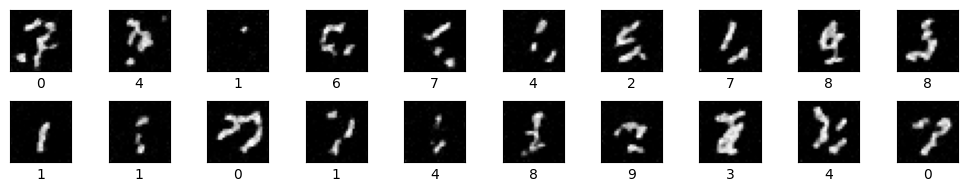

100%|██████████| 469/469 [04:53<00:00,  1.60it/s]


Epoch 1 | Loss: 0.027771612005764997


100%|██████████| 1000/1000 [01:01<00:00, 16.18it/s]


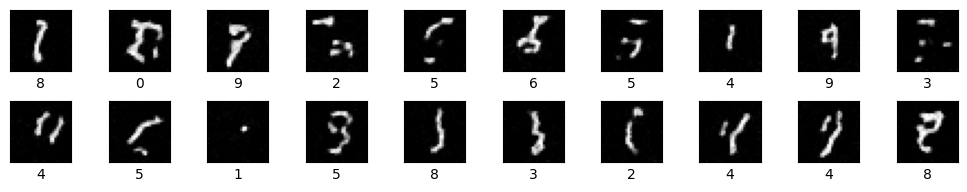

100%|██████████| 469/469 [05:21<00:00,  1.46it/s]


Epoch 2 | Loss: 0.02344116874769934


100%|██████████| 1000/1000 [00:35<00:00, 28.19it/s]


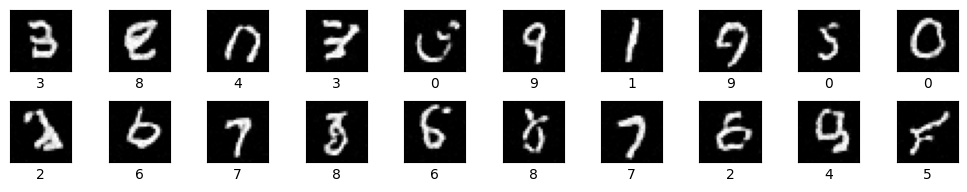

100%|██████████| 469/469 [04:40<00:00,  1.67it/s]


Epoch 3 | Loss: 0.0213692426117562


100%|██████████| 1000/1000 [00:39<00:00, 25.28it/s]


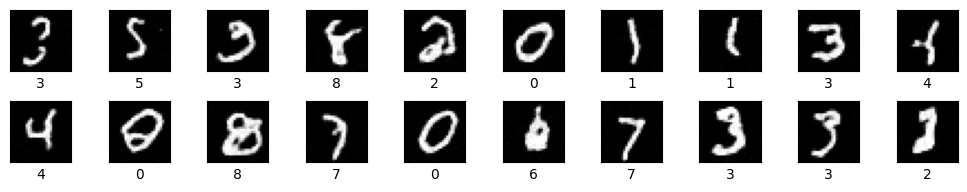

100%|██████████| 469/469 [03:46<00:00,  2.07it/s]


Epoch 4 | Loss: 0.020729460777329612


100%|██████████| 1000/1000 [00:32<00:00, 31.23it/s]


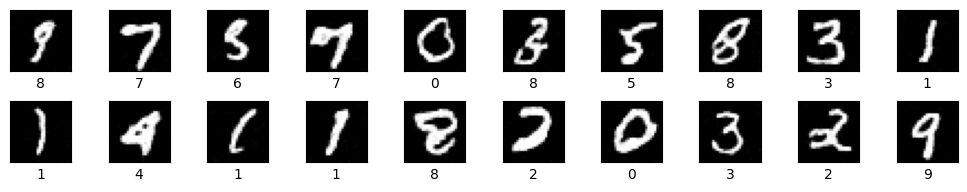

100%|██████████| 469/469 [03:07<00:00,  2.50it/s]


Epoch 5 | Loss: 0.01937547031797961


100%|██████████| 1000/1000 [00:25<00:00, 39.21it/s]


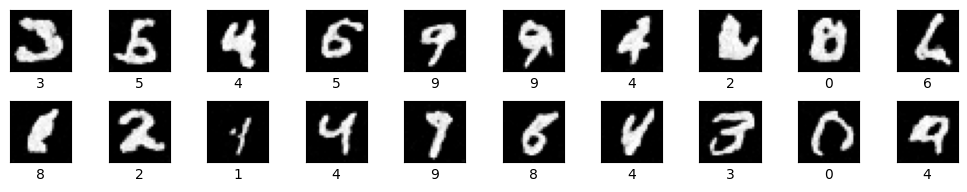

100%|██████████| 469/469 [03:26<00:00,  2.27it/s]


Epoch 6 | Loss: 0.01924526309971807


100%|██████████| 1000/1000 [00:24<00:00, 40.57it/s]


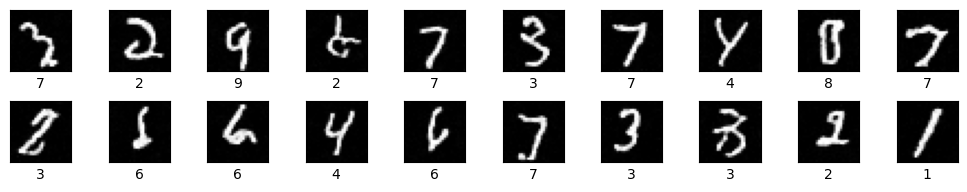

100%|██████████| 469/469 [03:30<00:00,  2.23it/s]


Epoch 7 | Loss: 0.018381143753319534


100%|██████████| 1000/1000 [00:34<00:00, 29.37it/s]


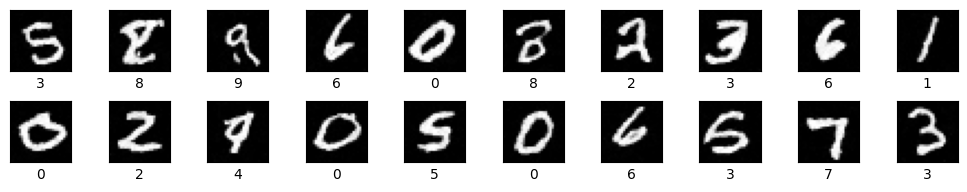

100%|██████████| 469/469 [03:25<00:00,  2.28it/s]


Epoch 8 | Loss: 0.017625888894949513


100%|██████████| 1000/1000 [00:39<00:00, 25.20it/s]


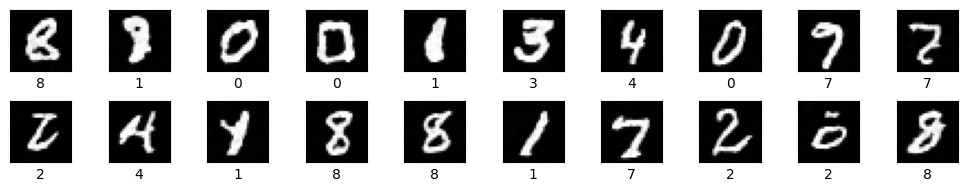

100%|██████████| 469/469 [03:42<00:00,  2.11it/s]

Epoch 9 | Loss: 0.0175111139637988


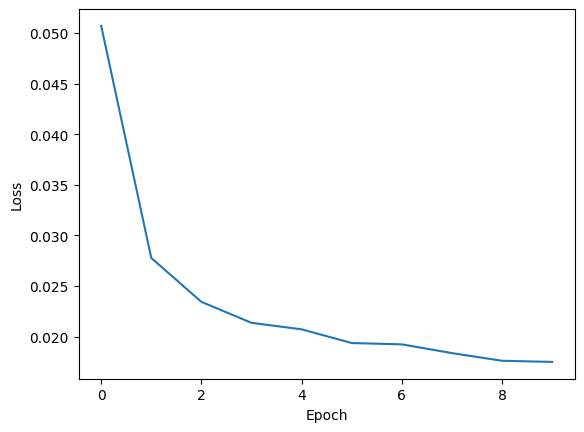

100%|██████████| 1000/1000 [00:28<00:00, 35.27it/s]


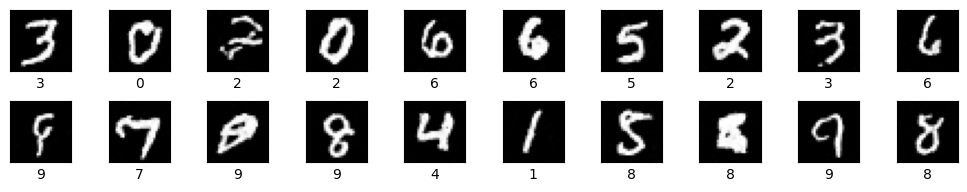

In [34]:
preprocess = transforms.ToTensor() # 前処理：テンソル変換
dataset = torchvision.datasets.MNIST(root='./data', download=True, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=gen) # 乱数源を指定

diffuser = Diffuser(num_timesteps, device=device)
# ① モデルをUnetCondに変更
model = UNetCond(num_labels=10)
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)

losses = []
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    # generate samples every epoch ===================
    images, labels = diffuser.sample(model)
    show_images(images, labels)
    # ================================================

    for images, labels in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)
        # ② ラベルをデバイスに転送
        labels = labels.to(device)
        t = torch.randint(1, num_timesteps+1, (len(x),), device=device, generator=gen) # 1からnum_timesteps(T)までのランダムな整数

        x_noisy, noise = diffuser.add_noise(x, t) # ノイズ追加済み画像とノイズを生成
        # ③ ラベルをモデルに渡す
        noise_pred = model(x_noisy, t, labels)
        loss = F.mse_loss(noise, noise_pred) # ノイズ予測と実際のノイズの平均二乗誤差

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(f'Epoch {epoch} | Loss: {loss_avg}')

# plot losses
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# generate samples
images, labels = diffuser.sample(model)
show_images(images, labels)

In [35]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': losses,
}, 'UnetCond_base_10.pth')


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:35<00:00, 28.45it/s]


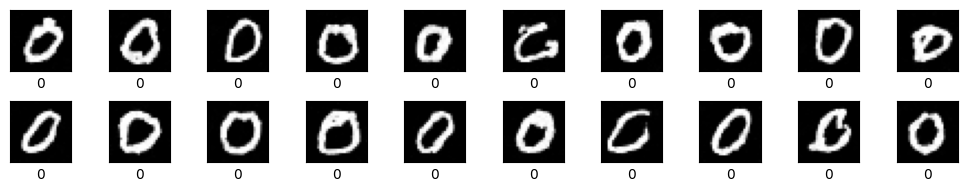

100%|██████████| 1000/1000 [00:32<00:00, 30.50it/s]


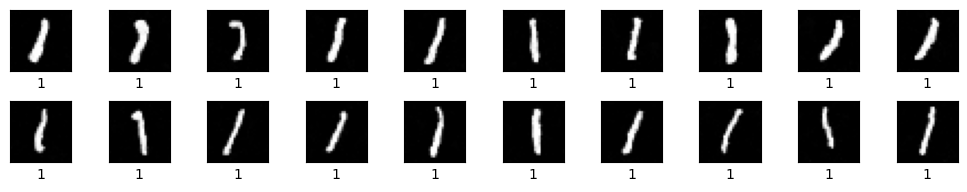

100%|██████████| 1000/1000 [00:30<00:00, 32.39it/s]


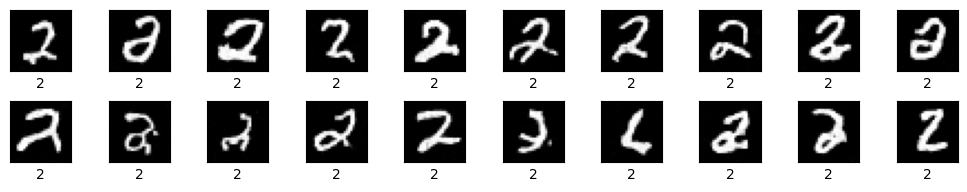

100%|██████████| 1000/1000 [00:25<00:00, 39.95it/s]


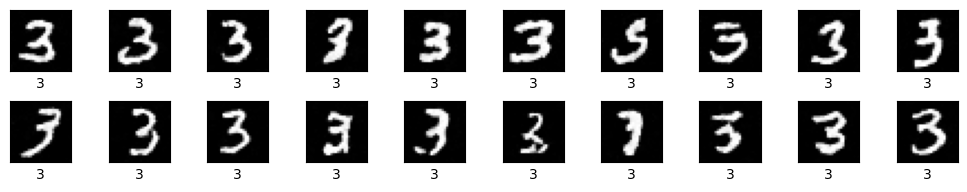

100%|██████████| 1000/1000 [00:23<00:00, 42.75it/s]


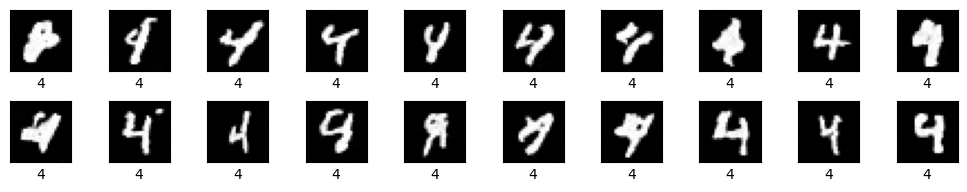

100%|██████████| 1000/1000 [00:31<00:00, 32.09it/s]


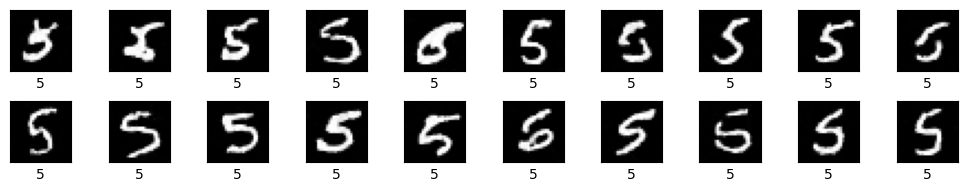

100%|██████████| 1000/1000 [00:23<00:00, 42.63it/s]


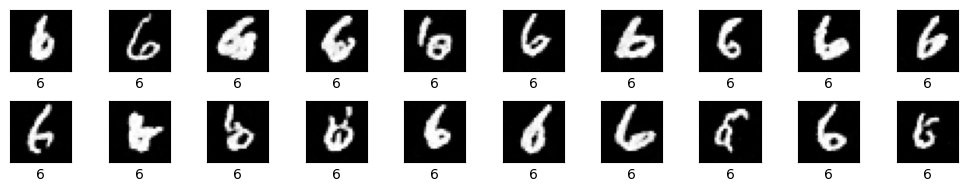

100%|██████████| 1000/1000 [00:27<00:00, 35.72it/s]


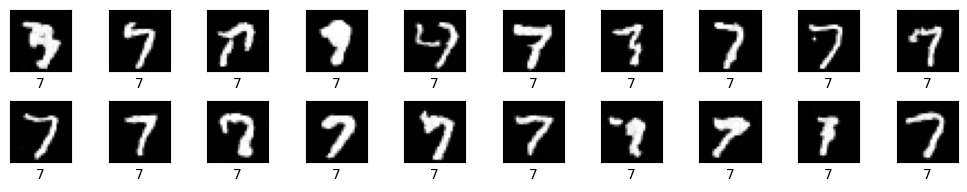

100%|██████████| 1000/1000 [00:25<00:00, 39.61it/s]


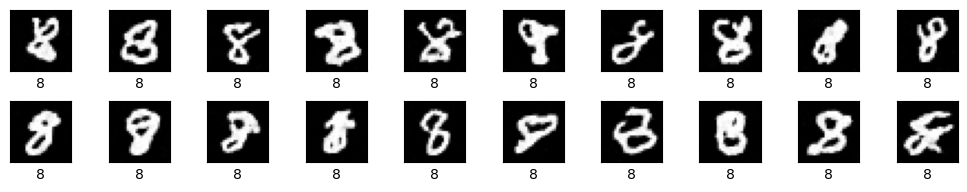

100%|██████████| 1000/1000 [00:28<00:00, 34.69it/s]


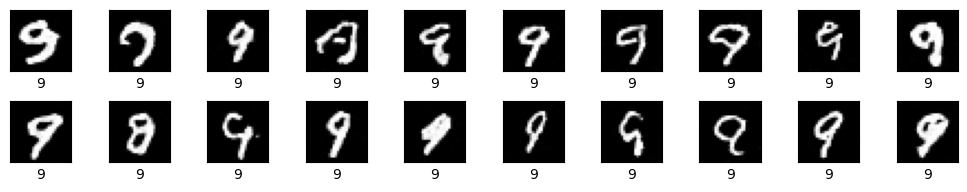

In [37]:
# 復元
checkpoint = torch.load('UnetCond_base_10.pth')

diffuser = Diffuser(num_timesteps, device=device)
model = UNetCond(num_labels=10)
optimizer = Adam(model.parameters(), lr=lr)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

# losses = checkpoint['loss']
# # print(losses)
# if isinstance(losses, torch.Tensor):
#     losses = losses.detach().cpu().numpy()
# plt.plot(losses)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss History')
# plt.show()

# images, labels = diffuser.sample(model) #, gen=gen)
# show_images(images, labels)

batch_size = 20 # sample関数で20枚をバッチサイズとして指定しているため
wanted_digits = [0,1,2,3,4,5,6,7,8,9]
for wanted_digit in wanted_digits:
    labels = torch.full((batch_size,), wanted_digit, dtype=torch.long, device=device)

    images, _  = diffuser.sample(model, labels=labels)  # x_shape デフォルト = (20,1,28,28)
    show_images(images, labels)

tensor(0.0135, requires_grad=True)


100%|██████████| 1000/1000 [00:23<00:00, 42.15it/s]


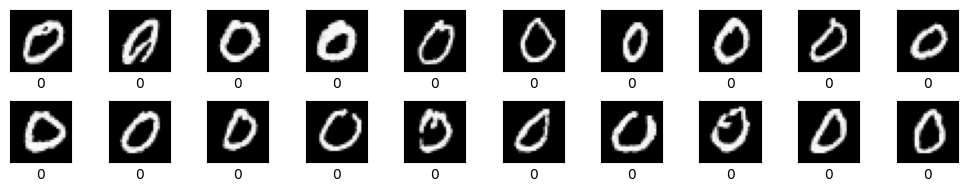

 20%|██        | 203/1000 [00:03<00:14, 54.07it/s]

100%|██████████| 1000/1000 [00:29<00:00, 33.73it/s]


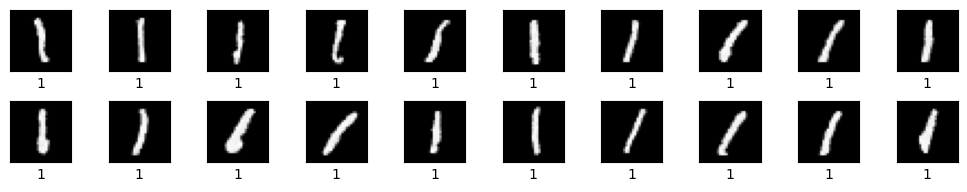

100%|██████████| 1000/1000 [00:29<00:00, 34.08it/s]


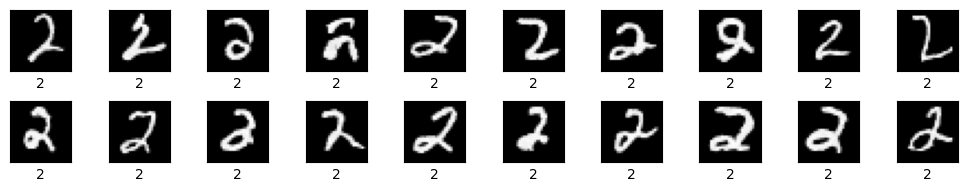

100%|██████████| 1000/1000 [00:25<00:00, 39.04it/s]


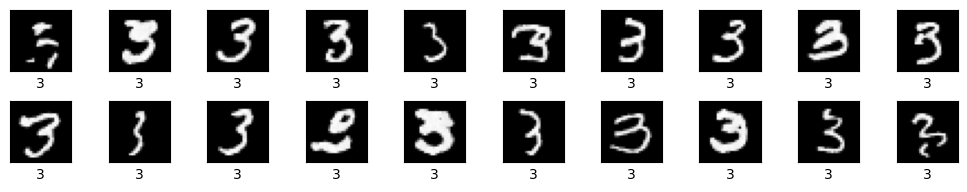

100%|██████████| 1000/1000 [00:24<00:00, 40.68it/s]


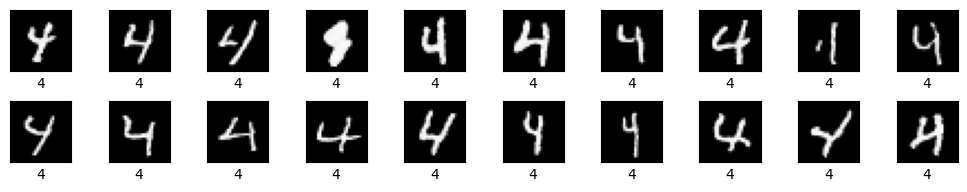

100%|██████████| 1000/1000 [00:29<00:00, 33.44it/s]


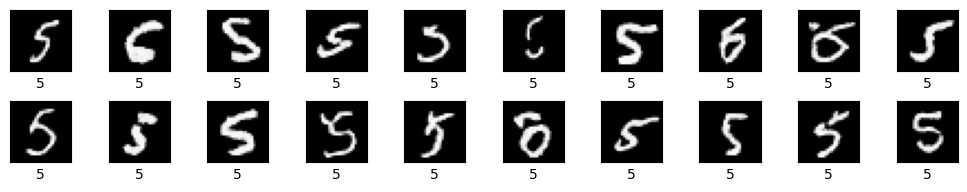

100%|██████████| 1000/1000 [00:25<00:00, 39.19it/s]


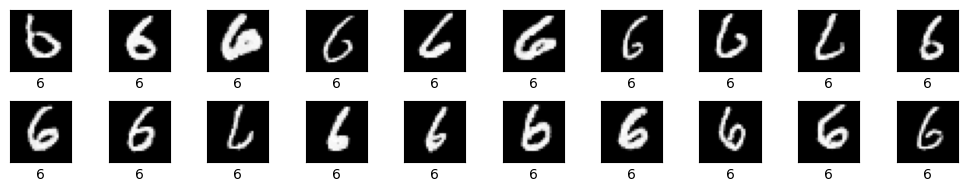

100%|██████████| 1000/1000 [00:24<00:00, 40.78it/s]


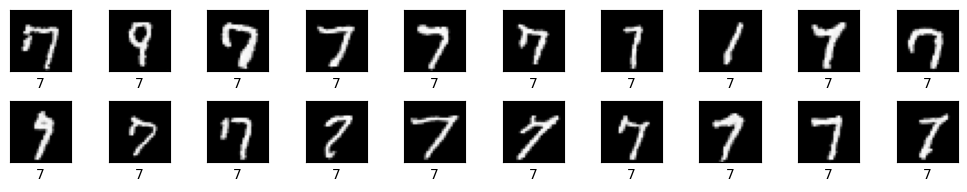

100%|██████████| 1000/1000 [00:20<00:00, 47.75it/s]


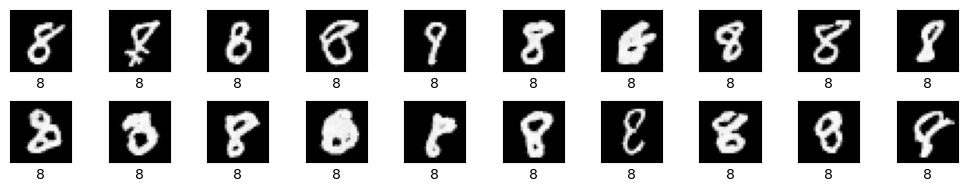

100%|██████████| 1000/1000 [00:26<00:00, 37.44it/s]


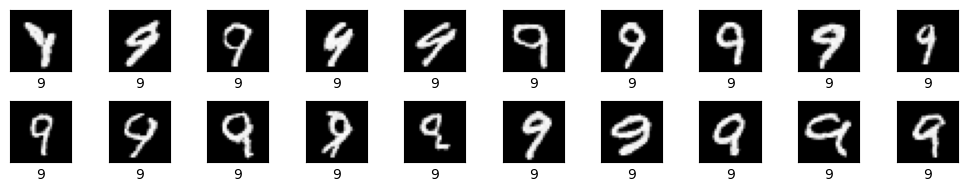

In [38]:
# 復元
checkpoint = torch.load('UnetCond_base_30.pth')
# print(checkpoint.keys())

# gen = torch.Generator(device=device).manual_seed(42)
diffuser = Diffuser(num_timesteps, device=device)
model = UNetCond(num_labels=10)
optimizer = Adam(model.parameters(), lr=lr)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

# images, labels = diffuser.sample(model) #, generator=gen)
# show_images(images, labels)

losses = checkpoint['loss']
print(losses)
# if isinstance(losses, torch.Tensor):
#     losses = losses.detach().cpu().numpy()
# plt.plot(losses)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss History')
# plt.show()

# 今回のモデルは，指定したラベルの画像を生成することができる
batch_size = 20 # sample関数で20枚をバッチサイズとして指定しているため
wanted_digits = [0,1,2,3,4,5,6,7,8,9]
for wanted_digit in wanted_digits:
    labels = torch.full((batch_size,), wanted_digit, dtype=torch.long, device=device)

    images, _  = diffuser.sample(model, labels=labels)  # x_shape デフォルト = (20,1,28,28)
    show_images(images, labels)


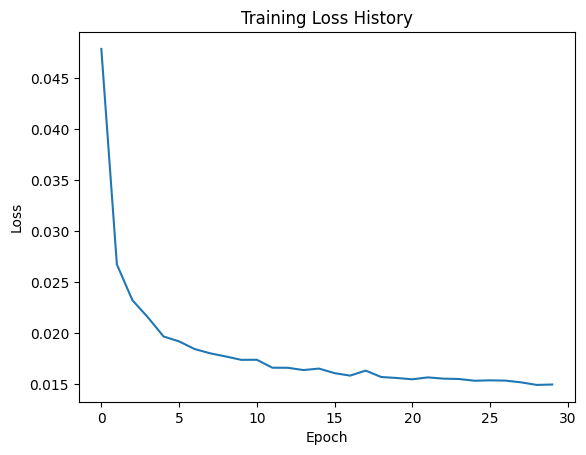

In [19]:
checkpoint = torch.load('UnetCond_base_30.pth')
# print(checkpoint.keys())

# gen = torch.Generator(device=device).manual_seed(42)
diffuser = Diffuser(num_timesteps, device=device)
model = UNetCond(num_labels=10)
optimizer = Adam(model.parameters(), lr=lr)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

# images, labels = diffuser.sample(model) #, generator=gen)
# show_images(images, labels)

losses = checkpoint['losses']
# print(losses)
if isinstance(losses, torch.Tensor):
    losses = losses.detach().cpu().numpy()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.show()

## 10.2 スコア関数
- ここまでは単純な条件付きモデルである
    - 条件が軽視・無視される可能性
- **ガイダンス手法**：与えられた条件をより強調して取り入れる（10.3）
    - スコア関数を利用する（10.2）

### 10.2.1 スコア関数とは
ノイズ$\epsilon_\theta (x_t, t)$推定モデルにおいて式(10.1)成立．
$$
\begin{align}
\varepsilon &\approx -\sqrt{1 - \bar{\alpha}_t} \nabla_{x_t} \log p(x_t) \tag{10.1}
\end{align}
$$

- $\nabla$＝勾配
- $\nabla_{x_t} \log p(x_t)$＝対数尤度$\log p(x_t)$の入力$x_t$に関する勾配＝**スコア関数（スコア）**
    - $p(x_t)$＝データ$x_t$の真の確率密度関数
    - $p_\theta (x_t)$＝真の確率密度関数をパラメータを用いて近似した確率密度関数
    - スコア関数は，上記のどちらの確率密度関数でもよい
<bm>

**→$\epsilon$はスコア関数で近似できる**
式(10.1)を変形することで，
$$\text{スコア関数} \approx -\frac{1}{\sqrt{1 - \bar{\alpha}_t}} \varepsilon$$
となり，新しいモデルとして以下のような**スコアを推定する拡散モデル**を実現できる．

![score_model](./data/score_model.jpg)
<bm>

- スコアベースモデル：スコアをモデル化（拡散モデル）
- 尤度ベースモデル：対数尤度を最大化（混合ガウスモデル，VAE，拡散モデル）

## 10.2.2 式(10.1)の証明
$$
\begin{align}
\varepsilon &\approx -\sqrt{1 - \bar{\alpha}_t} \nabla_{x_t} \log p(x_t) \tag{10.1}
\end{align}
$$

$$
\begin{align}
q(x_t \mid x_0) &= \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) \mathbf{I})
 \tag{10.2}
\end{align}
$$

<bm>

$$
\begin{align*}
\varepsilon &\sim \mathcal{N}(\mathbf{0}, \mathbf{I}) \\
x_t &= \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \varepsilon \tag{10.3}
\end{align*}
$$

##### Tweedieの公式
$$\mathbb{E}[\mu \mid x] = x + \Sigma \nabla_x \log p(x)$$
- $\mu$：確率変数
- $\mathbb{E}[\mu \mid x]$：$x$を条件としたときの，$\mu$の期待値
- 意味：指数関数型分布の真の平均は，その分布における標本の最尤推定値（経験平均）$x$に，推定値のスコアを含む何らかの補正項を加えたもので推定できること

$$
\begin{align*}
\mathbb{E}[\sqrt{\bar{\alpha}_t} x_0 \mid x_t] &= x_t + (1 - \bar{\alpha}_t) \mathbf{I} \nabla_{x_t} \log p(x_t) \\
&= x_t + (1 - \bar{\alpha}_t) \nabla_{x_t} \log p(x_t) \tag{10.4}
\end{align*}
$$

以上の式から，式(10.1)を証明する．（証明の詳細は以下の通り）

![syomei](./data/syomei.jpg)

## 10.3 分類器ガイダンス
### 10.3.1 分類器とは
- 分類器ガイダンス：分類器をつかってデータ生成をガイドする方法
    - 分類器：データ分類をする学習ずみニューラルネットワーク
- 入力$x_t$からクラス$y$の確率$p_\phi (y \mid x_t)$を出力する分類器を利用して条件付き拡散モデルを実現
- 重要ポイント
    - 拡散モデル：スコア$\nabla_{x_t} \log p(x_t)$を予測するNNで実現（p.245）
    - 条件付き拡散モデル：**条件付き確率スコア$\nabla_{x_t} \log p(x_t \mid y)$を予測するNNで実現**

### 10.3.2 分類器ガイダンスの導出
$$
\begin{align*}
p(x_t \mid y) &= \frac{p(x_t) p(y \mid x_t)}{p(y)} \tag{ベイズの定理}
\end{align*}
$$

$$
\begin{align*}
\nabla_{x_t} \log p(x_t \mid y) &= \nabla_{x_t} \log(\frac{p(x_t) p(y \mid x_t)}{p(y)}) \\
&= \nabla_{x_t} \log p(x_t) + \nabla_{x_t} \log p(y \mid x_t) - \nabla_{x_t} \log p(y) \\
&= \nabla_{x_t} \log p(x_t) + \nabla_{x_t} \log p(y \mid x_t)
\end{align*}
$$

$$\text{→条件付きスコア＝スコア＋分類器の対数尤度の勾配}$$

通常分類器ガイダンスは「重み$\gamma$（ハイパーパラメータ）」を取り入れ，分類器の貢献度を調整する．

$$
\begin{align*}
\nabla_{x_t} \log p(x_t \mid y) = \nabla_{x_t} \log p(x_t) + \gamma \nabla_{x_t} \log p(y \mid x_t) \tag{10.5}
\end{align*}
$$

つまり，分類器ガイダンスは，スコア推定NN $\mathcal{s}_\theta (x_t, t)$ と分類器 $p_{\varphi}(y \mid x_t)$ によって，以下の式となる．

$$
\begin{align*}
\nabla_{x_t} \log p(x_t \mid y) &\approx \mathcal{s}_\theta (x_t, t) + \gamma \nabla_{x_t} \log p_{\phi}(y \mid x_t) \tag{10.6}
\end{align*}
$$

![10_10](./data/10_10.jpg)

## 10.4 分類器なしガイダンス
分類器を用意する必要があるという問題を改善したモデルが，分類器なしガイダンス．
### 10.4.1 分類器なしガイダンスの理論

$$
\begin{align*}
\nabla_{x_t} \log p(x_t \mid y) &= \nabla_{x_t} \log p(x_t) + \gamma \nabla_{x_t} \log p(y \mid x_t)  \\
&= \nabla_{x_t} \log p(x_t) + \gamma \nabla_{x_t} \log \frac{p(x_t \mid y) p(y)}{p(x_t)} \text{　(ベイズの定理適用)} \\
&= \nabla_{x_t} \log p(x_t) + \gamma \left( \nabla_{x_t} \log p(x_t \mid y) + \nabla_{x_t} \log p(y) - \nabla_{x_t} \log p(x_t) \right) \\
&= \nabla_{x_t} \log p(x_t) + \gamma \left( \nabla_{x_t} \log p(x_t \mid y) - \nabla_{x_t} \log p(x_t) \right) \tag{10.7}
\end{align*}
$$

![explain_10_7](./data/explain_10_7.jpg)

つまり，条件なしスコア $\mathcal{s}_{\theta_1} (x_t, t)$ と，条件付きスコア $\mathcal{s}_{\theta_2} (x_t, t, y)$ で推定できるが，二つのモデルを用意するのは手間な為，**条件付きスコア$\mathcal{s}_{\theta} (x_t, t, y)$１つでモデル化する**．
- 条件なしスコア：$\mathcal{s}_{\theta} (x_t, t, \emptyset)$
- 条件付きスコア：$\mathcal{s}_{\theta} (x_t, t, y)$
$$
\begin{align*}
\nabla_{x_t} \log p(x_t \mid y) \approx s_{\theta}(x_t, t, \emptyset) + \gamma \left(s_{\theta}(x_t, t, y) - s_{\theta}(x_t, t, \emptyset) \right)
\end{align*}
$$


### 10.4.2 分類器なしガイダンスの実装

In [5]:
# Diffusionモデルに重みgamma追加

class Diffuser_gamma:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all() # 1以上T以下の整数であることを確認

        t_idx = t - 1  # alpha_bars[0] is for t=1
        alpha_bar = self.alpha_bars[t_idx]  # (N,)
        alpha_bar = alpha_bar.view(alpha_bar.size(0), 1, 1, 1)  # (N, 1, 1, 1)

        noise = torch.randn_like(x_0, device=self.device) # 元画像x0と同じ形状のノイズテンソル
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise # 変数変換トリック
        return x_t, noise # 時刻tのノイズ画像, ノイズ

    # 変更箇所：引数に重みgammaを追加
    def denoise(self, model, x, t, labels, gamma):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all() # 1以上T以下の整数であることを確認

        t_idx = t - 1  # alphas[0] is for t=1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx-1]

        # ブロードキャストのための形状変換
        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval()
        with torch.no_grad(): # 評価時には，勾配計算を無効化
            # 変更箇所：重みgammaをつかってノイズ\epsilonを予測
            eps = model(x, t, labels) # noiseである\epsilonの予測
            eps_uncond = model(x, t)
            eps = eps_uncond + gamma * (eps - eps_uncond) # 式(10.8)
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0  # t=1のときはノイズを0にする（最初の画像はノイズなし）

        mu = (x - ((1-alpha) / torch.sqrt(1-alpha_bar)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1-alpha) * (1-alpha_bar_prev) / (1-alpha_bar))
        return mu + noise * std

    def reverse_to_img(self, x): # テンソルxからPILイメージに変換（前処理でテンソルにしているため）
        x = x * 255
        x = x.clamp(0, 255) # 0-255の範囲に制限
        x = x.to(torch.uint8)
        x = x.cpu()
        to_pil = transforms.ToPILImage() # テンソルをPIL画像に変換
        return to_pil(x)

    def sample(self, model, x_shape=(20, 1, 28, 28), labels=None, gamma=3.0): # サンプリング関数（生成）
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device)

        if labels is None:
            labels = torch.randint(0, 10, (len(x),), device=self.device) # len(x)はバッチサイズ

        for i in tqdm(range(self.num_timesteps, 0, -1)):
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)
            x = self.denoise(model, x, t, labels, gamma)

        images = [self.reverse_to_img(x[i]) for i in range(batch_size)]
        return images, labels

In [8]:
# ハイパーパラメータの設定（gammaを追加）
img_size = 28
batch_size = 128
num_timesteps = 1000
epochs = 10
lr = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

100%|██████████| 1000/1000 [00:48<00:00, 20.78it/s]


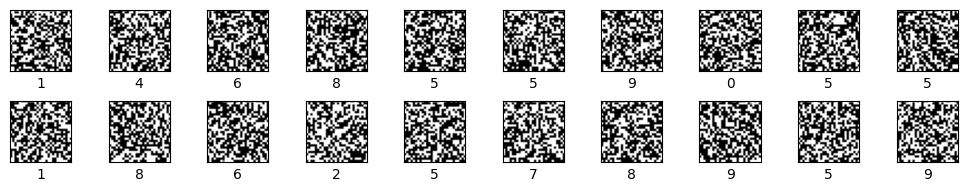

100%|██████████| 469/469 [03:22<00:00,  2.31it/s]


Epoch 0 | Loss: 0.04580151251177671


100%|██████████| 1000/1000 [00:52<00:00, 18.89it/s]


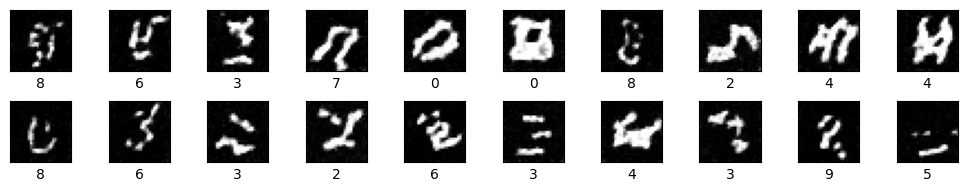

100%|██████████| 469/469 [03:12<00:00,  2.44it/s]


Epoch 1 | Loss: 0.02647793505674423


100%|██████████| 1000/1000 [00:43<00:00, 23.03it/s]


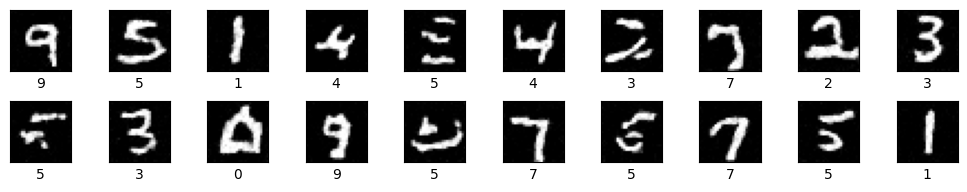

100%|██████████| 469/469 [02:54<00:00,  2.69it/s]


Epoch 2 | Loss: 0.023470436888081685


100%|██████████| 1000/1000 [01:02<00:00, 16.12it/s]


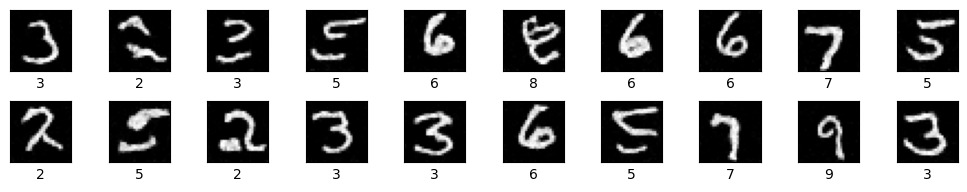

100%|██████████| 469/469 [02:54<00:00,  2.68it/s]


Epoch 3 | Loss: 0.021069604271987098


100%|██████████| 1000/1000 [00:54<00:00, 18.41it/s]


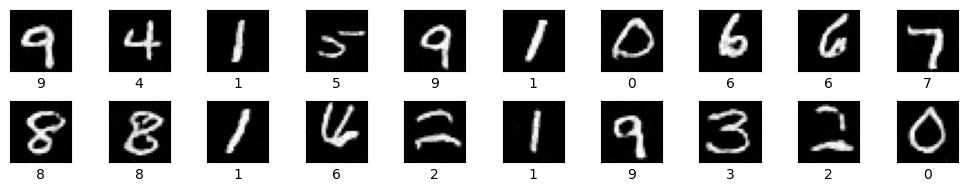

100%|██████████| 469/469 [03:01<00:00,  2.58it/s]


Epoch 4 | Loss: 0.02009872439454423


100%|██████████| 1000/1000 [00:45<00:00, 21.82it/s]


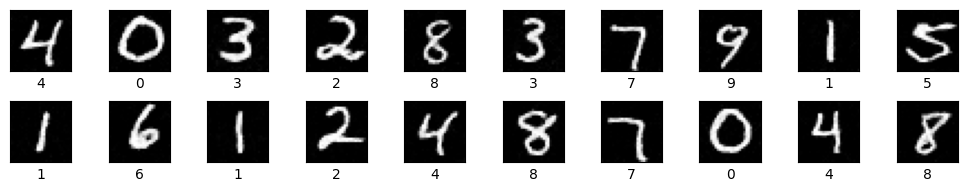

100%|██████████| 469/469 [02:51<00:00,  2.73it/s]


Epoch 5 | Loss: 0.01917207061545427


100%|██████████| 1000/1000 [00:55<00:00, 18.17it/s]


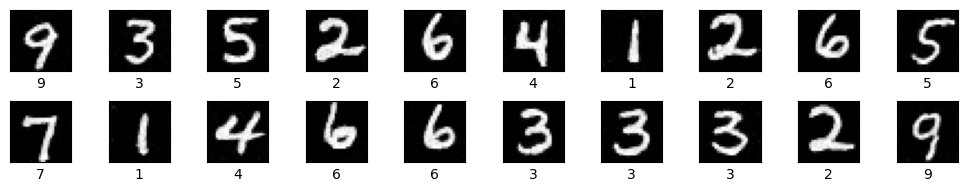

100%|██████████| 469/469 [02:51<00:00,  2.74it/s]


Epoch 6 | Loss: 0.0185781822982691


100%|██████████| 1000/1000 [00:48<00:00, 20.43it/s]


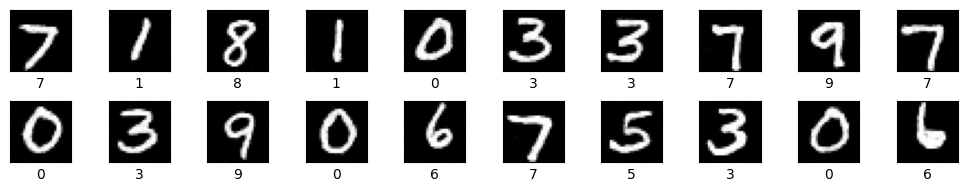

100%|██████████| 469/469 [02:57<00:00,  2.65it/s]


Epoch 7 | Loss: 0.018200596605838615


100%|██████████| 1000/1000 [00:48<00:00, 20.41it/s]


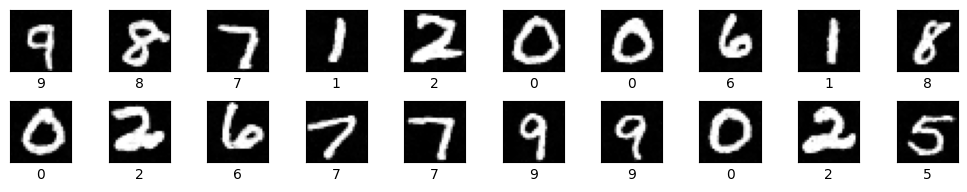

100%|██████████| 469/469 [02:58<00:00,  2.63it/s]


Epoch 8 | Loss: 0.017904621691925568


100%|██████████| 1000/1000 [00:50<00:00, 19.84it/s]


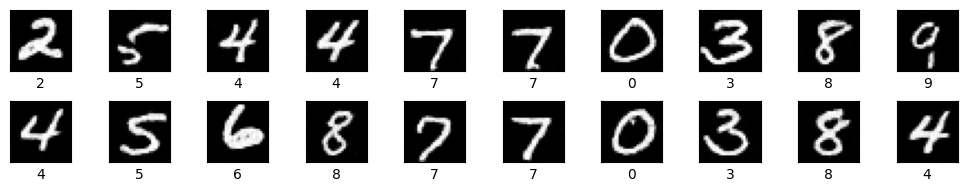

100%|██████████| 469/469 [03:03<00:00,  2.55it/s]

Epoch 9 | Loss: 0.017141615600585303


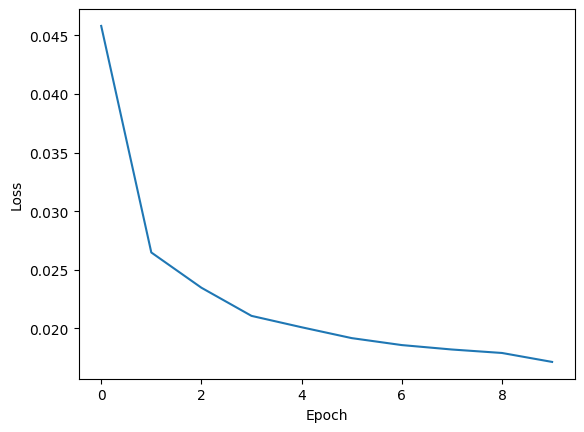

100%|██████████| 1000/1000 [00:50<00:00, 19.74it/s]


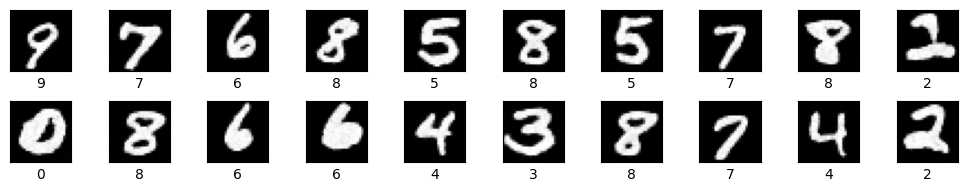

In [ ]:
preprocess = transforms.ToTensor() # 前処理：テンソル変換
dataset = torchvision.datasets.MNIST(root='./data', download=True, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=gen) # 乱数源を指定

diffuser = Diffuser_gamma(num_timesteps, device=device)
model = UNetCond(num_labels=10)
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)

losses = []
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    # generate samples every epoch ===================
    images, labels = diffuser.sample(model)
    show_images(images, labels)
    # ================================================

    for images, labels in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)
        labels = labels.to(device)
        t = torch.randint(1, num_timesteps+1, (len(x),), device=device, generator=gen) # 1からnum_timesteps(T)までのランダムな整数

        # 変更箇所：10％の確率でラベルをNoneにして，「条件なし」で学習
        if np.random.random() < 0.1:
            labels = None

        x_noisy, noise = diffuser.add_noise(x, t) # ノイズ追加済み画像とノイズを生成
        noise_pred = model(x_noisy, t, labels)
        loss = F.mse_loss(noise, noise_pred) # ノイズ予測と実際のノイズの平均二乗誤差

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(f'Epoch {epoch} | Loss: {loss_avg}')

# plot losses
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# generate samples
images, labels = diffuser.sample(model)
show_images(images, labels)

In [42]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': losses,
}, 'UnetCond_v2_10.pth')

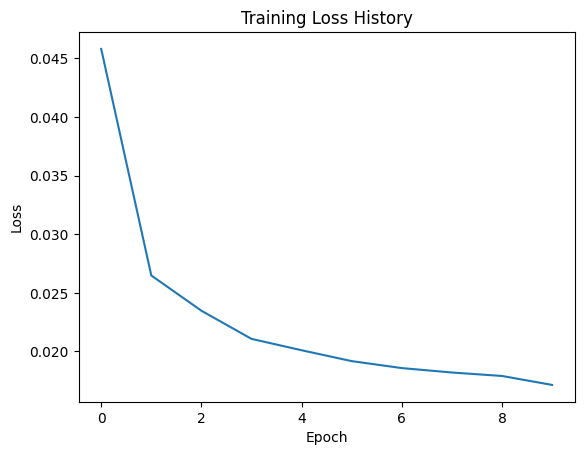

100%|██████████| 1000/1000 [01:11<00:00, 14.01it/s]


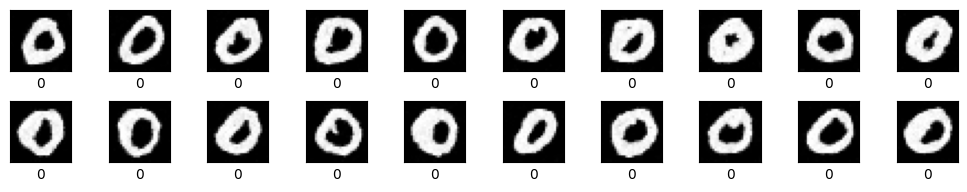

100%|██████████| 1000/1000 [00:49<00:00, 20.25it/s]


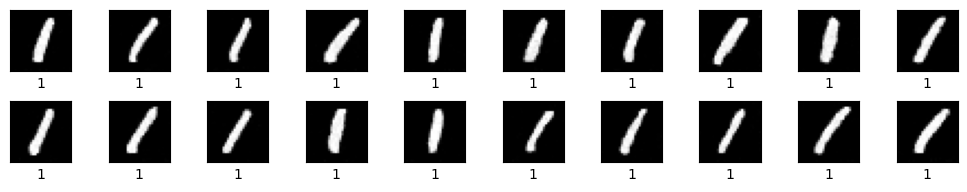

100%|██████████| 1000/1000 [00:55<00:00, 17.99it/s]


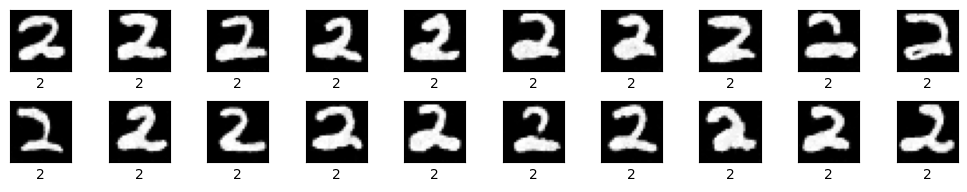

100%|██████████| 1000/1000 [00:43<00:00, 23.24it/s]


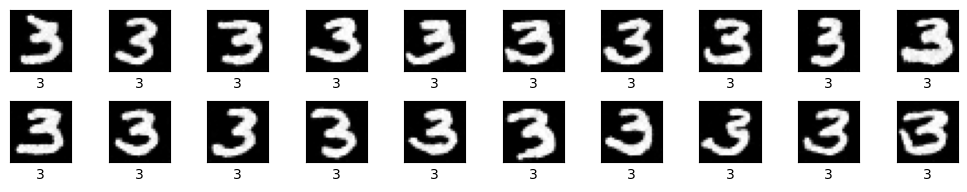

100%|██████████| 1000/1000 [00:52<00:00, 19.12it/s]


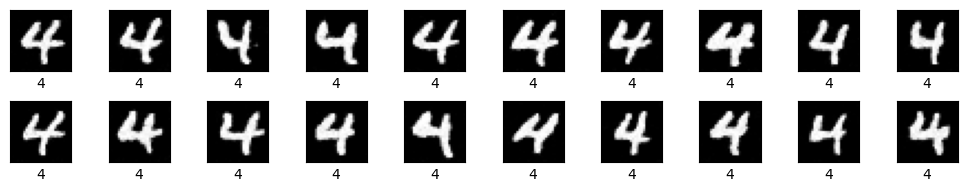

100%|██████████| 1000/1000 [00:48<00:00, 20.68it/s]


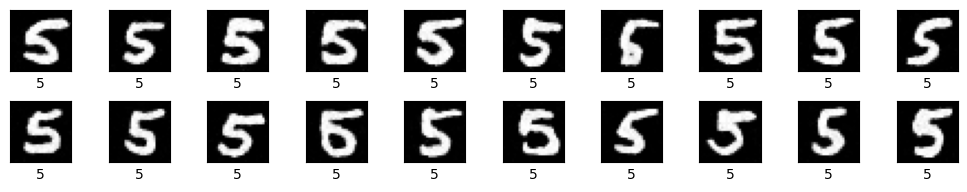

100%|██████████| 1000/1000 [00:51<00:00, 19.32it/s]


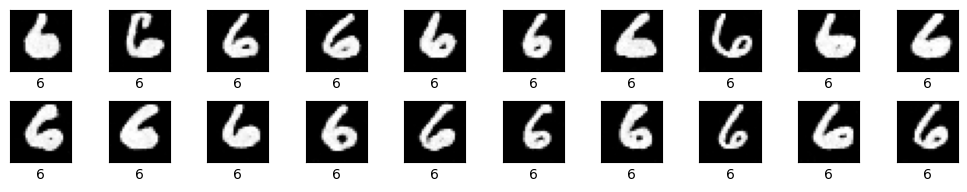

100%|██████████| 1000/1000 [00:47<00:00, 21.24it/s]


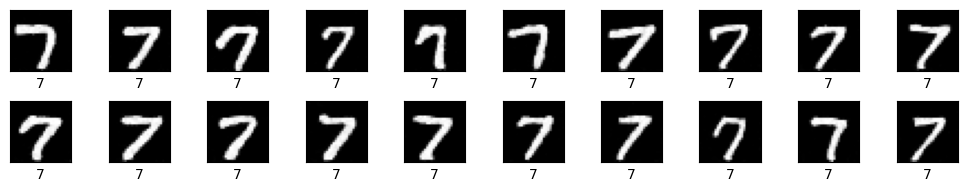

100%|██████████| 1000/1000 [00:49<00:00, 20.11it/s]


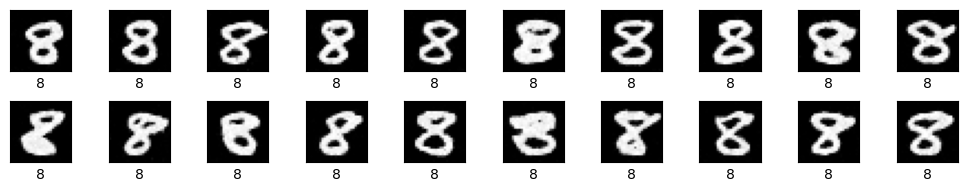

100%|██████████| 1000/1000 [00:51<00:00, 19.33it/s]


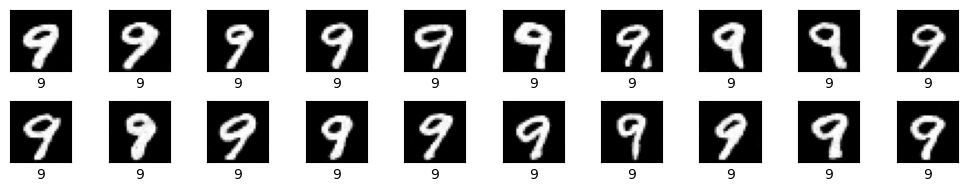

In [13]:
# 復元
checkpoint = torch.load('UnetCond_v2_10.pth')

diffuser = Diffuser_gamma(num_timesteps, device=device)
model = UNetCond(num_labels=10)
optimizer = Adam(model.parameters(), lr=lr)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

losses = checkpoint['loss']
# print(losses)
if isinstance(losses, torch.Tensor):
    losses = losses.detach().cpu().numpy()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.show()

# images, labels = diffuser.sample(model) #, gen=gen)
# show_images(images, labels)

batch_size = 20 # sample関数で20枚をバッチサイズとして指定しているため
wanted_digits = [0,1,2,3,4,5,6,7,8,9]
for wanted_digit in wanted_digits:
    labels = torch.full((batch_size,), wanted_digit, dtype=torch.long, device=device)

    images, _  = diffuser.sample(model, labels=labels)  # x_shape デフォルト = (20,1,28,28)
    show_images(images, labels)

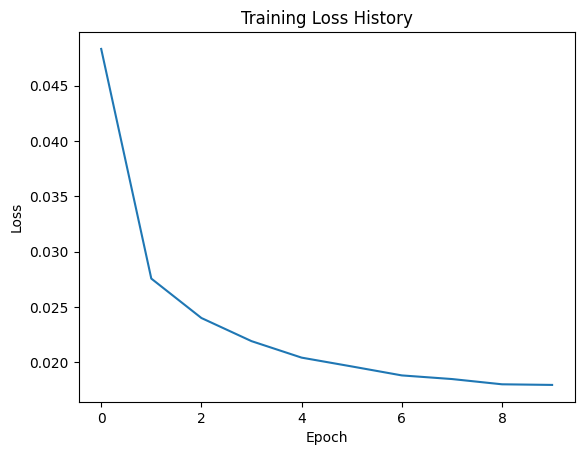

100%|██████████| 1000/1000 [00:50<00:00, 19.70it/s]


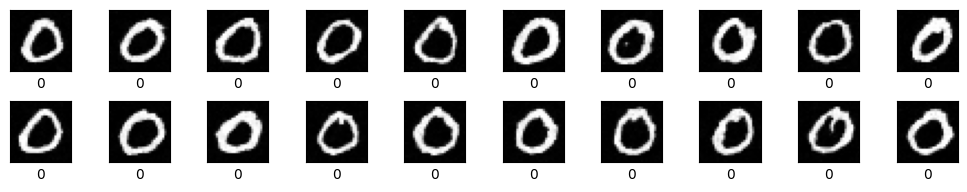

100%|██████████| 1000/1000 [06:26<00:00,  2.58it/s]


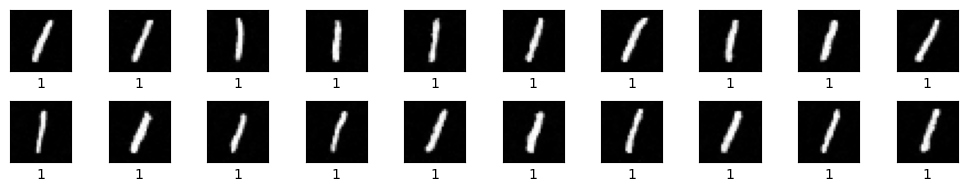

100%|██████████| 1000/1000 [02:19<00:00,  7.15it/s]


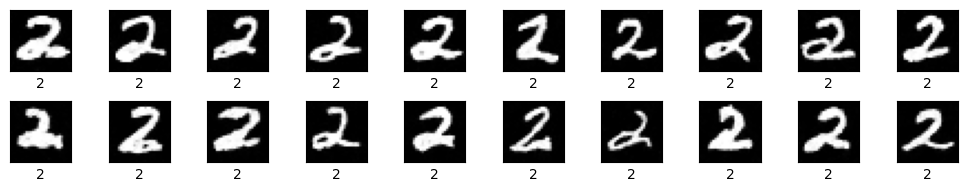

100%|██████████| 1000/1000 [00:44<00:00, 22.58it/s]


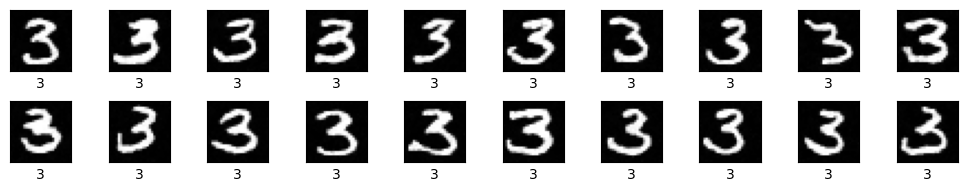

100%|██████████| 1000/1000 [00:56<00:00, 17.66it/s]


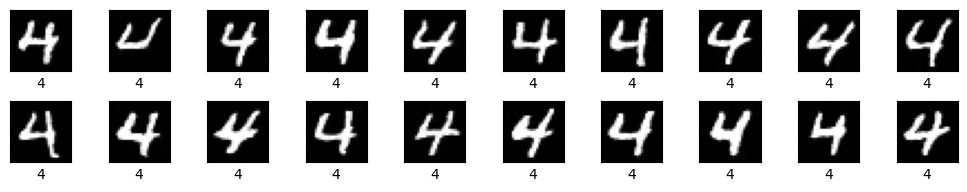

100%|██████████| 1000/1000 [00:49<00:00, 20.25it/s]


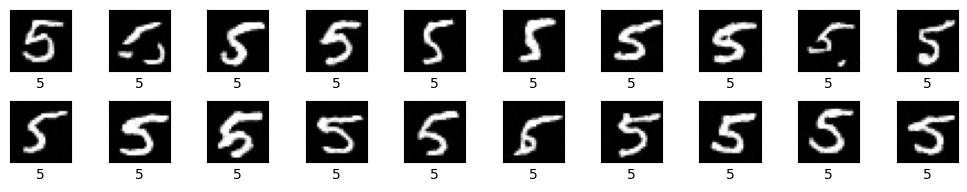

100%|██████████| 1000/1000 [00:48<00:00, 20.66it/s]


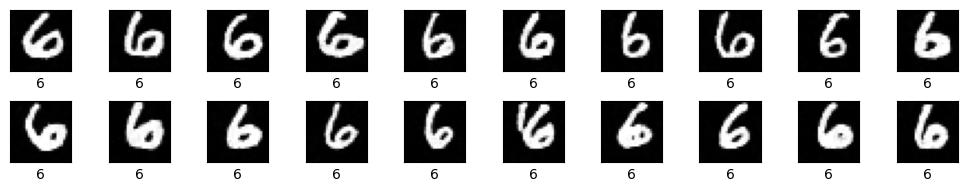

100%|██████████| 1000/1000 [00:45<00:00, 22.16it/s]


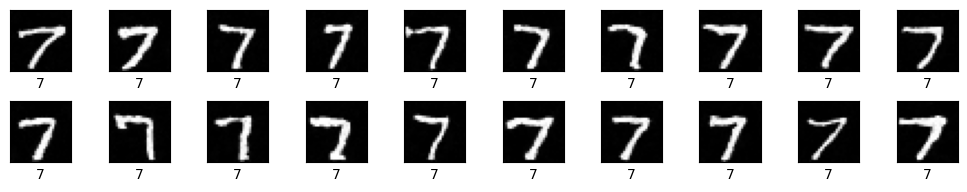

100%|██████████| 1000/1000 [00:44<00:00, 22.41it/s]


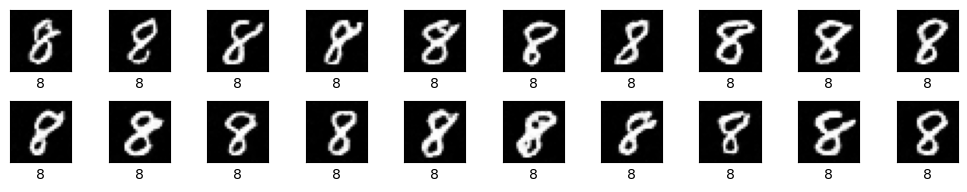

100%|██████████| 1000/1000 [00:44<00:00, 22.23it/s]


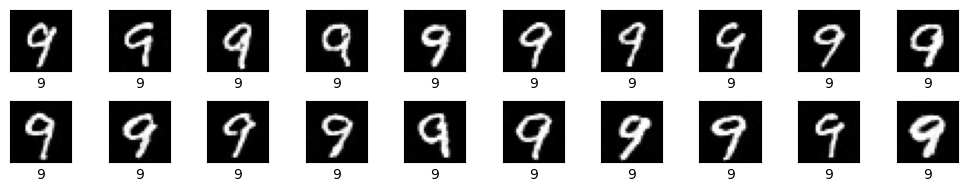

In [15]:
# 復元
checkpoint = torch.load('UnetCond_v2_gm10.pth')

diffuser = Diffuser_gamma(num_timesteps, device=device)
model = UNetCond(num_labels=10)
optimizer = Adam(model.parameters(), lr=lr)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

losses = checkpoint['losses']
# print(losses)
if isinstance(losses, torch.Tensor):
    losses = losses.detach().cpu().numpy()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.show()

# images, labels = diffuser.sample(model) #, gen=gen)
# show_images(images, labels)

batch_size = 20 # sample関数で20枚をバッチサイズとして指定しているため
wanted_digits = [0,1,2,3,4,5,6,7,8,9]
for wanted_digit in wanted_digits:
    labels = torch.full((batch_size,), wanted_digit, dtype=torch.long, device=device)

    images, _  = diffuser.sample(model, labels=labels)  # x_shape デフォルト = (20,1,28,28)
    show_images(images, labels)

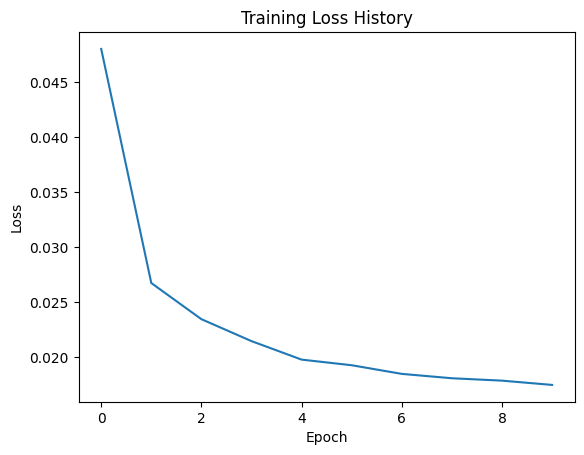

100%|██████████| 1000/1000 [01:00<00:00, 16.43it/s]


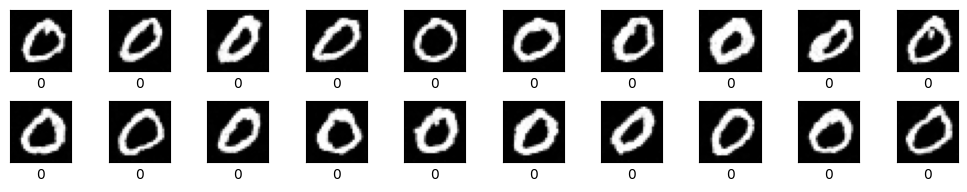

100%|██████████| 1000/1000 [00:49<00:00, 20.33it/s]


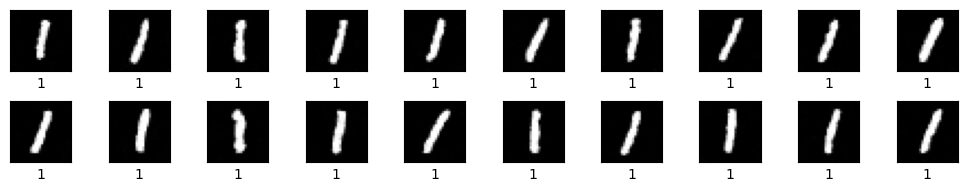

100%|██████████| 1000/1000 [02:25<00:00,  6.87it/s]


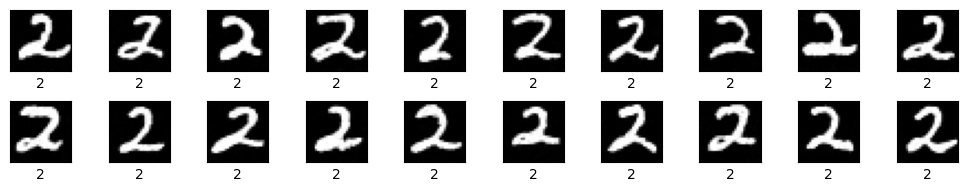

100%|██████████| 1000/1000 [01:21<00:00, 12.32it/s]


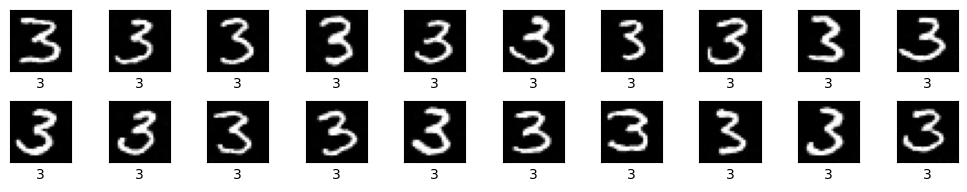

100%|██████████| 1000/1000 [01:16<00:00, 13.07it/s]


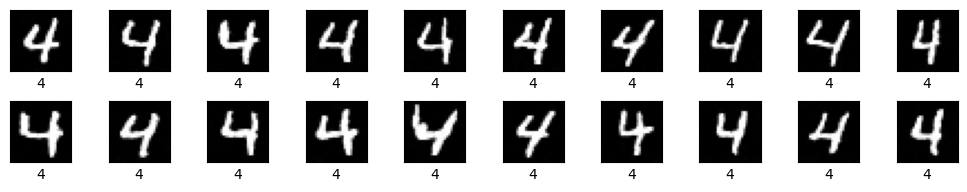

100%|██████████| 1000/1000 [01:49<00:00,  9.12it/s]


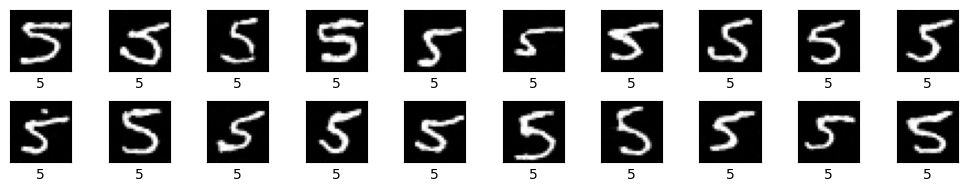

100%|██████████| 1000/1000 [01:47<00:00,  9.28it/s]


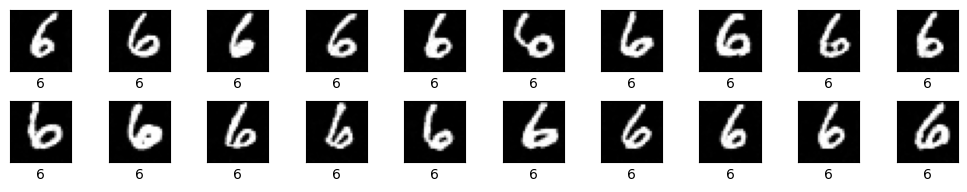

100%|██████████| 1000/1000 [01:18<00:00, 12.81it/s]


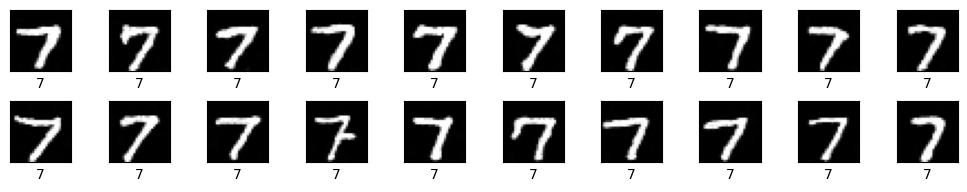

100%|██████████| 1000/1000 [01:33<00:00, 10.72it/s]


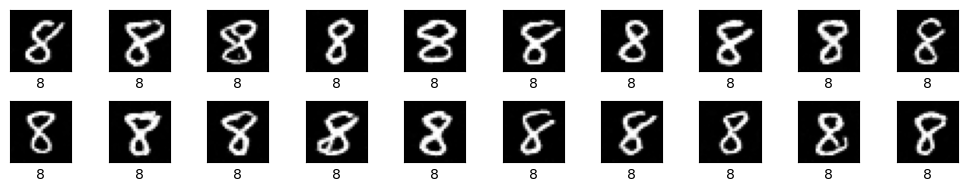

100%|██████████| 1000/1000 [01:14<00:00, 13.38it/s]


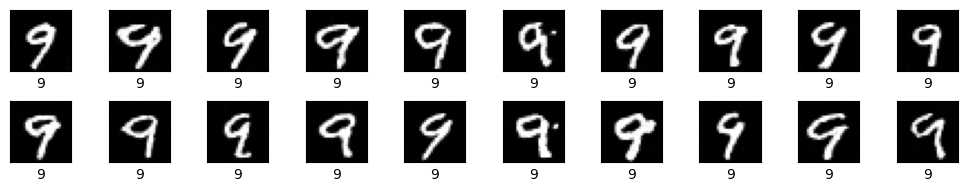

In [20]:
# 復元
checkpoint = torch.load('UnetCond_v2_nonCond0-01.pth')

diffuser = Diffuser_gamma(num_timesteps, device=device)
model = UNetCond(num_labels=10)
optimizer = Adam(model.parameters(), lr=lr)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

losses = checkpoint['losses']
# print(losses)
if isinstance(losses, torch.Tensor):
    losses = losses.detach().cpu().numpy()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.show()

# images, labels = diffuser.sample(model) #, gen=gen)
# show_images(images, labels)

batch_size = 20 # sample関数で20枚をバッチサイズとして指定しているため
wanted_digits = [0,1,2,3,4,5,6,7,8,9]
for wanted_digit in wanted_digits:
    labels = torch.full((batch_size,), wanted_digit, dtype=torch.long, device=device)

    images, _  = diffuser.sample(model, labels=labels)  # x_shape デフォルト = (20,1,28,28)
    show_images(images, labels)

## 10.5 Stable Diffusion
https://github.com/CompVis/stable-diffusion

### 10.5.1 Stable Diffusionの仕組み
##### 学習の流れ
![10_15](./data/10_15.jpg)
##### データ生成の流れ
![10_16](./data/10_16.jpg)

- 潜在空間：潜在空間で拡散モデルの処理を行う
- CLIP：テキストエンコーディングにCLIPというニューラルネットワークを利用
- Attention：Attention層をつかってU-Netに「条件」を取り入れる

#### 潜在空間
- ここまでの拡散モデル
    - ピクセル空間（各時刻データが元画像と同じベクトル空間）で処理する
- Stable Diffusion
    - 潜在空間（潜在変数の空間）で処理する
    - 学習
        - エンコーダ（VAEで使用したモデル）を用いて，ピクセル空間から潜在空間に変換
        - 潜在変数の次元数を小さくすることで，拡散モデルの処理を削減
    - データ生成
        - 潜在空間のガウスノイズからスタートし，逆拡散過程を行う
        - 最後の逆拡散過程終了後，VAEエンコーダでピクセル空間に変換

#### CLIP
- 画像エンコーダ：画像→ベクトル
- テキストエンコーダ：テキスト→ベクトル
- 画像とテキストエンコーダそれぞれによる「ベクトルの類似度」が高くなるように，損失関数設定
    - コサイン類似度：-1.0 ~ 1.0（値が大きいほど, ベクトルの為す角の大きさが小さく，類似度が高い）
$$
\text{コサイン類似度}(\boldsymbol{a},\boldsymbol{b}) = \frac{\boldsymbol{a} \cdot \boldsymbol{b}}{\|\boldsymbol{a}\| \, \|\boldsymbol{b}\|}
$$
- テキストエンコーダによるベクトル＝拡散モデルにおける条件

#### Attention
- 条件付き拡散モデルでの条件について
    - 今回実装したモデル：条件ベクトル＋時刻ベクトル
    - Stable Diffusion：Attention層で条件を取り入れる
- Crass-Attention
    - ２つの入力データの類似度計算，類似度を重みとしてもう一方の入力に乗じる
    - 重要な情報に注意を払うことができる

![Attention](./data/Attention.jpg)

### 10.5.2 Diffusersライブラリ
https://huggingface.co/docs/diffusers/